In [1]:
# imports

from drn_interactions.transforms.spikes import SpikesHandlerMulti
from drn_interactions.config import ExperimentInfo
from drn_interactions.io import load_derived_generic
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import minmax_scale
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
sns.set_theme(context="paper", style="ticks")

In [3]:
# loaders

SESSIONS = ExperimentInfo.foot_shock_sessions_10min


def load_piv_all(
    session,
):
    sh = SpikesHandlerMulti(
        block=["base_shock", "post_base_shock"],
        session_names=[session],
        bin_width=1,
        t_start=-600,
        t_stop=1200,
    )
    return sh.binned_piv

def load_bin_all(
    session,
):
    sh = SpikesHandlerMulti(
        block=["base_shock", "post_base_shock"],
        session_names=[session],
        bin_width=1,
        t_start=-600,
        t_stop=1200,
    )
    return sh.binned

def load_bin_first_half():
    sh = SpikesHandlerMulti(
        block=["base_shock", "post_base_shock"],
        session_names=None,
        bin_width=1,
        t_start=-600,
        t_stop=1200,
    )
    df = sh.binned
    df = (
        df
        .loc[lambda x: ~(x.bin.between(300, 600)) & ~(x.bin > 900)]
        .set_index("bin")
    )
    return df


def load_bin_second_half():
    sh = SpikesHandlerMulti(
        block=["base_shock", "post_base_shock"],
        session_names=None,
        bin_width=1,
        t_start=-600,
        t_stop=1200,
    )
    df = sh.binned
    df = (
        df
        .loc[lambda x: ~(x.bin.between(0, 300)) & ~(x.bin.between(600, 900))]
        .set_index("bin")
    )
    return df


In [4]:
# preprocessors

def heatmap_preprocess(df_spikes, neurons, minmax=True, tfidf=False):
    if tfidf:
        tfidf = TfidfTransformer()
        df_spikes = pd.DataFrame(
            tfidf.fit_transform(df_spikes).toarray(),
            index=df_spikes.index,
            columns=df_spikes.columns,
        )
    if minmax:
        df_spikes = df_spikes.transform(minmax_scale)

    df_spikes = get_neuron_key(df_spikes, neurons)
    df_spikes = df_spikes.T
    return df_spikes


def heatmap_nt_key(df_spikes):
    ...

def lineplot_preprocess(df_spikes):
    ...


def get_neuron_key(df_spikes, neurons):
    "order by neuron type - SR, SIR, FF"
    cols_unsorted = df_spikes.columns
    cols_sorted = (
        neurons
        .query("neuron_id in @cols_unsorted")
        .sort_values("neuron_type", ascending=False)
        .neuron_id
        .values
        .tolist()
    )
    return df_spikes[cols_sorted]

In [5]:
# plotters


def plot_heatmap(df_spikes, ax, vlines=True, **kwargs):
    sns.heatmap(df_spikes, cmap="Greys", ax=ax, cbar=False, **kwargs)
    ax.xaxis.set_major_locator(plt.MultipleLocator(300))
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.axvline(600, color="red", linewidth=1.5)
    ax.axvline(1200, color="red", linewidth=1.5)
    return ax

In [6]:
# gogo
session = SESSIONS[5]

neurons = load_derived_generic("neuron_types.csv")
df_all = load_piv_all(session)
# df_fh = load_piv_first_half(SESSIONS[0])
# df_sh = load_piv_second_half(SESSIONS[0])

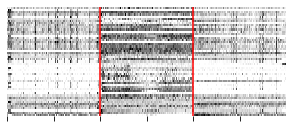

In [10]:
from drn_interactions.config import Config


df = heatmap_preprocess(df_all, neurons=neurons, tfidf=False)

f = plt.figure(figsize=(5, 2))

ax = f.subplots()
plot_heatmap(df, ax)

f.savefig(Config.fig_dir / "slow fs example heatmap.png", dpi=300)

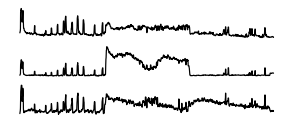

In [11]:
from scipy.signal import medfilt

f = plt.figure(figsize=(5, 2))
axes = f.subplots(3)

df_bin = (
    load_bin_all(session)
    .merge(neurons[["neuron_id", "neuron_type"]])
)

df_nt = (
    df_bin
    .groupby(["bin", "neuron_type"])["counts"]
    .mean()
    .reset_index()
    .pivot(index="bin", columns="neuron_type", values="counts")
    .transform(medfilt, kernel_size=5)
    .transform(minmax_scale)
)

for i, nt in enumerate(("SR", "SIR", "FF")):
    axes[i].plot(df_nt[nt], color="black")
    axes[i].axis("off")

f.savefig(Config.fig_dir / "slow fs example by nt.png", dpi=300)

In [12]:
from drn_interactions.stats import mannwhitneyu_plusplus, p_adjust
from scipy.stats import zmap



def _prepost(ser):
    x = ser[ser.index < 0]
    y = ser[ser.index > 0]
    return mannwhitneyu_plusplus(x, y)

def _zmap(ser):
    base = ser[ser.index < 0]
    return zmap(ser, base)


def prepost_shock(df, col="zcounts", thresh=0.2):
    df = df.reset_index().query("bin < 600").set_index("bin")
    df_res =  df.groupby("neuron_id")[col].apply(_prepost).unstack().reset_index()
    df_res["p_adj"] = p_adjust(df_res.p)
    df_res["sig"] = (df_res.p_adj < 0.05) & (df_res["Diff"].abs() > thresh)
    df_res["response"] = np.select(
        condlist=[
            (df_res.sig) & (df_res.Diff > 0), 
            (df_res.sig) & (df_res.Diff < 0),
            ~(df_res.sig)
            ],
        choicelist=["Activated", "Inhibited", "No Effect"],
        )
    return df_res


df_fh = load_bin_first_half()
df_fh["zcounts"] = df_fh.groupby("neuron_id")["counts"].transform(_zmap)
df_res_fh = prepost_shock(df_fh, col="counts").merge(neurons[["neuron_id", "neuron_type"]])

df_sh = load_bin_second_half()
df_sh["zcounts"] = df_sh.groupby("neuron_id")["counts"].transform(_zmap)
df_res_sh = prepost_shock(df_sh, col="counts").merge(neurons[["neuron_id", "neuron_type"]])

Mutual Information: 0.38
Spearman Correlation: 0.85 (p=0.00)


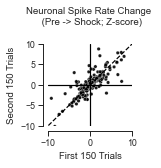

In [19]:
from sklearn.metrics import adjusted_mutual_info_score
from scipy.stats import spearmanr

def merge_responders(df_fh, df_sh, col):
    df = (
        df_fh.set_index("neuron_id")[[col]]
        .join(df_sh.set_index("neuron_id")[[col]], lsuffix="_fh", rsuffix="_sh")
    )
    return df


categorical = merge_responders(df_res_fh, df_res_sh, "response")
mi = adjusted_mutual_info_score(categorical.response_fh, categorical.response_sh)

numeric = merge_responders(df_res_fh, df_res_sh, "Diff").dropna()
corr, corr_p = spearmanr(numeric.Diff_fh, numeric.Diff_sh)

print(f"Mutual Information: {mi:.2f}")
print(f"Spearman Correlation: {corr:.2f} (p={corr_p:.2f})")


f = plt.figure(figsize=(1.5, 1.5))
ax = f.subplots()

sns.scatterplot(
    data=numeric,
    x="Diff_fh",
    y="Diff_sh",
    ax=ax,
    color="black",
    alpha=0.9,
    size=10
)

ax.axline((0,0), slope=1, color="black", linestyle="--")
ax.axhline(0, color="black", linestyle="-")
ax.axvline(0, color="black", linestyle="-")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_ylabel("Second 150 Trials")
ax.set_xlabel("First 150 Trials")
ax.set_title("Neuronal Spike Rate Change \n (Pre -> Shock; Z-score)", pad=20)
ax.legend().remove()
sns.despine(ax=ax, offset=5)

f.savefig(Config.fig_dir / "slow fs consistency.png", dpi=300, bbox_inches="tight")

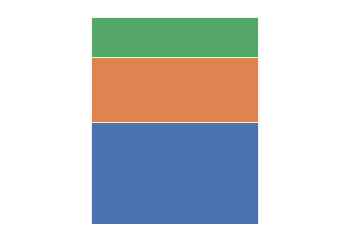

In [17]:
def stacked_bar_single(df, col, ax):
    df[col].value_counts().to_frame().T.plot(kind="bar", stacked=True, ax=ax, legend=False)
    ax.axis("off")
    return ax


_, ax = plt.subplots()
df.reset_index()[["neuron_id"]].merge(neurons).pipe(stacked_bar_single, "neuron_type", ax=ax)
plt.savefig(Config.fig_dir / "slow fs neuron types.png", dpi=300)